<a href="https://colab.research.google.com/github/ashishsalunkhe/Fraudulent-Review-Detection-using-CNN-LSTM-and-Word-Embeddings/blob/master/deceptive_true_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [0]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:
df = pd.read_csv('../input/binaryclassreview/final-output.csv')

In [0]:
df.head()

,deceptive_polarity,text
0,truthful,We stayed for a one night getaway with family ...
1,truthful,Triple A rate with upgrade to view room was le...
2,truthful,This comes a little late as I'm finally catchi...
3,truthful,The Omni Chicago really delivers on all fronts...
4,truthful,I asked for a high floor away from the elevato...


In [0]:
df=df.sample(frac=1)

In [0]:
df.head()

,deceptive_polarity,text
847,truthful,The Omni was chosen for it's location whichwor...
966,truthful,me (taking a cue from david dancer): 'sup? fro...
881,truthful,"As a frequent traveler for work, I stay at man..."
1509,deceptive,During my stay at the Hilton Chicago it has be...
382,truthful,After reading some of the most recent reviews ...


In [0]:

x = df['text'].astype(str)
y = df['deceptive_polarity']

In [0]:
np.unique(df['deceptive_polarity'])

array(['deceptive', 'truthful'], dtype=object)

In [0]:
class_mapping = {label:idx for idx,label in enumerate(np.unique(df['deceptive_polarity']))}

In [0]:
class_mapping

{'deceptive': 0, 'truthful': 1}

In [0]:
df['deceptive_polarity']= df['deceptive_polarity'].map(class_mapping)

In [0]:
#pre-processing
import re 
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\n", "", string)    
    string = re.sub(r"\r", "", string) 
    string = re.sub(r"[0-9]", "digit", string)
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()
x = []
for i in range(df.shape[0]):
    x.append(clean_str(df.iloc[i][1]))
y = np.array(df["deceptive_polarity"])

In [0]:
train, test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

In [0]:
tokenizer = Tokenizer(num_words=None,lower=True,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=' ',char_level=False)
tokenizer.fit_on_texts(train)

In [0]:
x_train = tokenizer.texts_to_sequences(train)

In [0]:
x_test = tokenizer.texts_to_sequences(test)
word_index = tokenizer.word_index

In [0]:
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in x_train)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in x_train])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in x_train])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))

Vocab size: 8210
Longest comment size: 784
Average comment size: 148.89333333333335
Stdev of comment size: 87.3040393618124
Max comment size: 410


In [0]:
processed_x_train = pad_sequences(x_train, maxlen=max_len)
processed_x_test = pad_sequences(x_test, maxlen=max_len)

In [0]:
processed_post_x_train = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
processed_post_x_test = pad_sequences(x_test, maxlen=max_len, padding='post', truncating='post')

In [0]:
embeddings_index = {}
f = open(os.path.join('../input/glove-embeddings-100d/', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 100
k = 0
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        k += 1
        embedding_matrix[i] = embedding_vector

In [0]:
import keras.backend
from keras.models import Sequential, load_model
from keras.layers import CuDNNGRU, Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization, LSTM
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Nadam
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

In [0]:
# Initate model
model = Sequential()

# Add Embedding layer
model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))

# Add Recurrent layer
#model.add(Bidirectional(CuDNNGRU(300, return_sequences=True)))
model.add(LSTM(60, return_sequences=True, name='lstm_layer'))
model.add(LSTM(30, return_sequences=True, name='lstm_layer2'))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

# Add fully connected layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 410, 100)          821100    
_________________________________________________________________
lstm_layer (LSTM)            (None, 410, 60)           38640     
_________________________________________________________________
lstm_layer2 (LSTM)           (None, 410, 30)           10920     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 410, 128)          19328     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 136, 128)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
__________

In [0]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [0]:
model_hist = model.fit(processed_x_train,y_train,validation_data=(processed_x_test,y_test),epochs=10,batch_size=32,verbose=1)

Train on 1200 samples, validate on 400 samples
Epoch 1/10
1200/1200 [==============================] - 28s 24ms/step - loss: 0.5745 - acc: 0.7033 - val_loss: 0.9581 - val_acc: 0.5600
Epoch 2/10
1200/1200 [==============================] - 24s 20ms/step - loss: 0.3660 - acc: 0.8492 - val_loss: 2.6369 - val_acc: 0.5175
Epoch 3/10
1200/1200 [==============================] - 24s 20ms/step - loss: 0.2808 - acc: 0.8825 - val_loss: 0.4075 - val_acc: 0.8350
Epoch 4/10
1200/1200 [==============================] - 24s 20ms/step - loss: 0.1691 - acc: 0.9400 - val_loss: 0.4199 - val_acc: 0.8425
Epoch 5/10
1200/1200 [==============================] - 24s 20ms/step - loss: 0.1089 - acc: 0.9608 - val_loss: 3.3884 - val_acc: 0.5475
Epoch 6/10
1200/1200 [==============================] - 25s 21ms/step - loss: 0.0496 - acc: 0.9900 - val_loss: 0.4748 - val_acc: 0.8525
Epoch 7/10
1200/1200 [==============================] - 25s 21ms/step - loss: 0.0472 - acc: 0.9833 - val_loss: 0.4606 - val_acc: 0.8450
E

In [0]:
import matplotlib.pyplot as plt

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


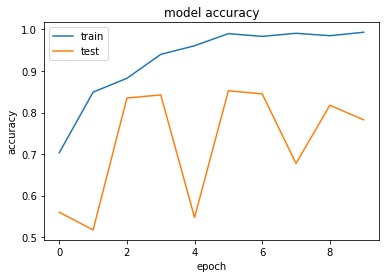

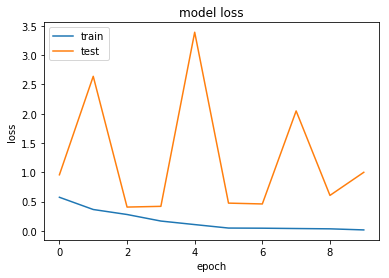

In [0]:
print(model_hist.history.keys())
# summarize history for accuracy
plt.plot(model_hist.history['acc'])
plt.plot(model_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.save('model-2layerlstm100d-9950-8525.h5')

In [0]:
"""validation_data=([processed_x_test,processed_post_x_test],y_test),"""